# **COURSEWORK 2 : Neural Style Transfer**

In the world of social media and digital marketing, visual appeal is paramount. NST can enhance the attractiveness of images by applying trendy and captivating styles, making them more engaging and shareable. Influencers and marketers can use this technique to stand out in the crowded digital landscape

An application of Neural Style Transfer, which I am to explore, is in the transformation of regular pictures of people combined with the styles often associated with influencers or models. This has significant implications for the fashion and social media industries.

The aim of this project is to develop a model where users can upload two images and have the colour gradient and style of those images blend in an attempt to bridge the gap in colour correction quality

In [1]:
!pip install tensorflow

import os

import numpy as np
import tensorflow as tf

import sys
import time
import pathlib

from PIL import Image
import matplotlib.pyplot as plt

## General Setup following the notebook

First the data is prepared, I chose 2 images with relatively centralised formats, the pictures taken have similar height and width, the people are similar distance away from the camera and take up about the same amont of space in the photo. This was all to make it easier on myself to see the effects of each model at each stage. The images used were taken from a free image providing website and are all licenced for comercial and non-comercial use.

The content and style images were loaded and stored.

In [2]:
# Create dataset directory
DATASET_DIR = pathlib.Path("neural-style-transfer")
if not DATASET_DIR.is_dir():
    os.mkdir(DATASET_DIR)

# Download the reference image
REF_IMAGE = tf.keras.utils.get_file(
    "content.jpg",  # Name of the file to save
    origin="https://img.freepik.com/free-photo/serious-young-man-standing-outdoors-with-his-arms-crossed_1262-19037.jpg",  # Direct image URL
    cache_dir=DATASET_DIR,
    cache_subdir="",
)

print(f"Image downloaded to: {REF_IMAGE}")
STYLE_IMAGE = tf.keras.utils.get_file(
    "Stylised_photo.jpg",
    origin="https://img.freepik.com/free-photo/close-up-portrait-man-looking-camera-outdoors_23-2148283854.jpg",
    cache_dir=DATASET_DIR,
    cache_subdir="",
)

70134/70134 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
Image downloaded to: neural-style-transfer/content.jpg
97317/97317 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


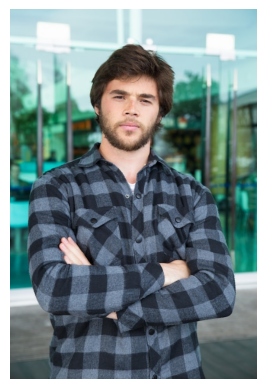

In [3]:
plt.axis('off')
plt.imshow(tf.keras.utils.load_img(REF_IMAGE))

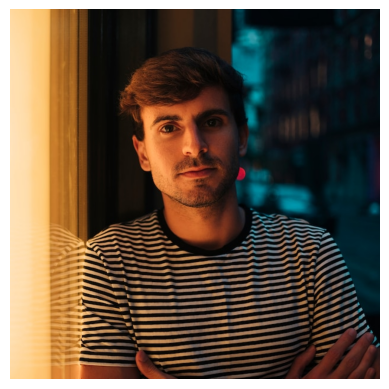

In [4]:
plt.axis('off')
plt.imshow(tf.keras.utils.load_img(STYLE_IMAGE))

---

## Neural style transfer in Keras

1. Use a pretrained convnet e.g. **VGG19** (VGG16 + 3 extra conv. layers), it is beneficial as it has already been pre-trained on a large dataset of images called ImageNet with an accuracy of 74% to 82.4%.
2. Compute the layer activations for the style-reference image and the original image *once* before the training loop;
3. During the loop, compute the activations for the generated image, and the losses;
3. Minimise the total loss with gradient descent (incrementally change the image).

In [5]:
original_width, original_height = tf.keras.utils.load_img(REF_IMAGE).size

# The images dimensions are limited
max_dim = 512
long_dim = max(original_width, original_height)
scale = max_dim / long_dim

img_height = round(original_height * scale)
img_width = round(original_width * scale)

In [6]:
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(                          # load image, specifying the size
        image_path, target_size=(img_height, img_width)
    )
    img = tf.keras.utils.img_to_array(img)                  # to array
    img = np.expand_dims(img, axis=0)                       # add batch dim
    img = tf.keras.applications.vgg19.preprocess_input(img) # specific VGG19 preprocessing
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939                       # vgg19.preprocess_input zero centers data by
    img[:, :, 1] += 116.779                       # removing the mean channel value from ImageNet:
    img[:, :, 2] += 123.68                        # here, we simply do this process in reverse
    img = img[:, :, ::-1]                         # vgg19.preprocess_input has BGR channels, reversed here to RGB
    img = np.clip(img, 0, 255).astype("uint8")
    return img

The previous pre-trained vgg19 model can be used as a feature extractor.

In [7]:
model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

# new model that returns all its layers outputs
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

As stated previously my aim in this project is for a user to be able to take one image and transfer the style, colour and look of it onto another picture. Essentioally merging the two pictures witout fully combining them as shapes may get in the way of this. With that in mind after some research I realised I can do this by tweaking the the loss function in the code.  

There are three different loss functions being used, Content Loss, Style Loss and Variation Loss. Content loss targets the higher-level structure specifically the deeper layers such as conv4_2. this makes up a large portion of all the recogniseable objects in the image for example in a picture of a cat, the shape, pose, and general composition of the cat.

In [9]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img)) # squared distance

The gram matrix is calculated through obtaining the features in the image (lines, edges, dots, etc) , and finding the correlation between them. This produces a correlation matrix where each number produced represents the realtionship between the features. This allow the algorithm to compute the images numercally.

In [10]:
def gram_matrix(x):
    """
    Calculate the correlations across features.
    Returns the Gram Matrix, of shape (f, f):
        the correlation score of every feature with itself and all others.
    """
    x = tf.transpose(x, (2, 0, 1))                     # x from (w, h, f) → (f,w,h), features first
    features = tf.reshape(x, (tf.shape(x)[0], -1))     # flatten w & h (-1: "calculate that dimension for me")
    gram = tf.matmul(features, tf.transpose(features)) # matmul: featurewise product & sum over all elements
    return gram

             # ↓ we pass a pre-computed gram matrix for the style image
def style_loss(style_img_gram, combination_img):
    C = gram_matrix(combination_img) # get gram matrix (feature correlations) for the combination image
    channels = 3
    size = img_height * img_width
         # ↓ the squared difference between the correlations of two matrices
    return tf.reduce_sum(tf.square(style_img_gram - C)) / (4.0 * (channels ** 2) * (size ** 2))
                                                         # ↑ normalisation constant

The code below helps in visualising the output it displays the behind the scene work being done during computing time.

In [11]:
def gram_matrix_v(x, verbose=False):
    """
    A verbose version of the gram matrix function,
    demonstrating how one can use the print function
    to look at the inner workings of the computation.
    """
    if verbose:
        print("x shape:         ", x.shape)
    x = tf.transpose(x, (2, 0, 1))
    if verbose:
        print("x reshaped:      ", x.shape)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    if verbose:
        print("features shape:  ", features.shape)
        print("transposed shape:", tf.transpose(features).shape)
    gram = tf.matmul(features, tf.transpose(features))
    if verbose:
        print("gram shape:      ", gram.shape)
    return gram

gram_matrix_v(preprocess_image(REF_IMAGE)[0], verbose=True)

x shape:          (512, 341, 3)
x reshaped:       (3, 512, 341)
features shape:   (3, 174592)
transposed shape: (174592, 3)
gram shape:       (3, 3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[8.1361446e+08, 7.4860416e+08, 5.8540800e+08],
       [7.4860416e+08, 7.6859021e+08, 6.6087443e+08],
       [5.8540800e+08, 6.6087443e+08, 8.6133581e+08]], dtype=float32)>

Total Variation Loss increases the smoothness, removes the noise, of the image by minimising the difference in pixel value with it's neighbouring pixels.

In [12]:
def total_variation_loss(x):
    """
    Operation on the generated image: 'encourages spatial continuity in
    the generated image, thus avoiding overly pixelated results', DLWP, p. 388.
    """

    # variations: vertical & horizontal
    a = tf.square( #                                      ↓ shift by one
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    ) #        ↑ reduce overall dims as we shift by 1 pixel, also here ↑

    b = tf.square( #                                                        ↓ shift by one
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    ) #        ↑ reduce overall dims as we shift by 1 pixel, also here ↑

    return tf.reduce_sum(tf.pow(a + b, 1.25)) # somewhat mysterious number here

By using hyperparameter tuning i can optimise the algorithm to achieve the best performance. The parameters can be used tweak the style-content balance, optimization process, and model architecture

In [13]:
# HYPERPARAMS: TWEAK ME!
content_layer_names = [             # the content layer
    "block5_conv2",
    "block4_conv4"
]

style_layer_names = [               # the style layers
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
                                  # Chollet:
total_variation_weight = 1e-6     # 1e-6
style_weight = 2.5e-7               # 1e-6
content_weight = 2.5e-10             # 2.5e-8

num_content_layers = len(content_layer_names)
num_style_layers = len(style_layer_names)

In [14]:
base_image = preprocess_image(REF_IMAGE)
style_reference_image = preprocess_image(STYLE_IMAGE)

content_features = feature_extractor(base_image)

content_targets = {                                         # 1. CONTENT TARGETS:
    layer_name: content_features[layer_name]                #    extract only the content layers we need
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_names
}

style_features = feature_extractor(style_reference_image)

style_targets = {                                          # 2. STYLE TARGETS:
    layer_name: gram_matrix(style_features[layer_name][0]) #    extract style layers, pre-compute the grams
    for layer_name, value                            # ↑ no batch size!
    in style_features.items()
    if layer_name in style_layer_names
}

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 512, 341, 3))
  warnings.warn(msg)


The style and content loss functions are then weighted and averaged then added together and minimised. This is then combined to calculate the final loss function that is used in the final algorithm to compute the changes variance in the outputs.

The variation loss is not included as that is used to remove noise an smothe the image after the final loss is computed.

In [15]:
def compute_loss(combination_image):

    all_combination_features = feature_extractor(combination_image)

    c_loss = tf.zeros(shape=())                                                    # 1. CONTENT LOSS
    for layer_name in content_layer_names:
        base_image_features = content_targets[layer_name][0] # ← no ↓ batch dim    # precomputed content features
        combination_features = all_combination_features[layer_name][0]
        c_loss += content_loss(base_image_features, combination_features)
    c_loss *= content_weight / num_content_layers                                  # weighting and averaging
            # ↑ (all layers with the same weight: could be changed!)

    s_loss = tf.zeros(shape=())                                                    # 2. STYLE LOSS
    for layer_name in style_layer_names:
        style_reference_features = style_targets[layer_name]                       # precomputed style features (grams!)
        combination_features = all_combination_features[layer_name][0]
        s_loss += style_loss(style_reference_features, combination_features)
    s_loss *= style_weight / num_style_layers                                      # weighting and averaging
            # ↑ (all layers with the same weight: could be changed!)

    v_loss = total_variation_weight * total_variation_loss(combination_image)      # 3. VARIATION LOSS
    loss = c_loss + s_loss + v_loss

    return loss, c_loss, s_loss, v_loss # returning everything so I can print values during training!

In [16]:
@tf.function # make it fast by compiling the function with @tf.function!
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss, c_loss, s_loss, v_loss

learning_rate = 80.

# plain old Adam works fine
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1
)

# To be tried: Chollet has vanilla SGD + learning rate decay:
# optimizer = tf.keras.optimizers.SGD(
#     tf.keras.optimizers.schedules.ExponentialDecay( # gradually lowers the learning rate!
#         initial_learning_rate=learning_rate,
#         decay_steps=100,
#         decay_rate=0.96
#     )
# )

In [17]:
from pickle import TRUE
combination_image = tf.Variable(preprocess_image(REF_IMAGE)) # THE IMAGE WE LEARN (COMBINATION)

iterations = 400    # Chollet: 4000
display_every = 100
print_every = 20
save_intermediate = True

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = DATASET_DIR / f"combination_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()

img = deprocess_image(combination_image.numpy())

SAVE = False
if SAVE:
    RESULTS_DIR = DATASET_DIR / "results"
    RESULTS_DIR.mkdir(exist_ok=True)
    fname = RESULTS_DIR / f"combination_image_at_iteration_{iterations}.png"
    tf.keras.utils.save_img(fname, img)

KeyboardInterrupt: 

In [ ]:
Image.open(fname)

## Conclusion

After messing around with the hyperparameters I had realised the effect the hyperparameters had on each image, it was fascinating to see the strength of the distortion increased eventhough I had turned down the style loss. I had gone about also changing the learning rate, turning it down to see if there were any local minimums that were affecting the models ability to learn but it didnt really affect much. The images produced succeeden in colour transfer but got stuck on the striped lines on the shirt from the stylised image. It would be interesting to see what effect increased momentum would have especially for escaping a local minimum maybe it could help reduce the content blend from the shirt.

I had tried adjusting the variation loss but its effect on the image was almost negligable. Also many of the pictures I had tried to import i was unable to as the websites had most likely blocked hotlinking. After going through all the hyperparameters, I had included the "block4_conv4" layer as part of the content layer as it is another deep layer, to see if it had an affect on the noise from the stylised image but there was no change.

## References

https://www.tensorflow.org/tutorials/generative/style_transfer

(Youtube) Why Gram Matrix in Style Transfer: https://www.youtube.com/watch?v=Elxnzxk-AUk&ab_channel=DevelopersHutt

WENGER, Jeremie (2022), Artificial Intelligence Notebooks, Goldsmiths, University of London

CHOLLET, Francois (2021) Deep learning with python, 2nd Edition, Manning